In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HB-PHD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn105031,MDATSAQLNCKTGQLSPPTQKTSIREHEFGSRSLDSEATEEKDAVS...,933,1
1,Achn332691,MSDDINMDATSAQLNCETRQLSPPTQKTLIREHEFGSRSLASEAAE...,954,1
2,EMT16215,MDKSNTSGCAEDTIETRSYANSSLNPEALKHQSFPFPYTSLSGERK...,1236,1
3,EMT18532,MAHEHAFFFGVTLMVNNTIICATCSLKEDTLDNDIILCDGACKRGF...,570,1
4,AA102G00135,MGEIKGRSGKEPEKPCEIGSTLLSSFLKKGGNAAKRRKYKKSETND...,713,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
276,0.004286,0.002857,0.005714,0.008571,0.004286,0.004286,0.002857,0.004286,0.007143,0.005714,...,0.000000,0.000000,0.000000,0.001429,0.002857,0.0,0.000000,0.0,0.0,0.000000
447,0.005263,0.002105,0.002105,0.004211,0.000000,0.002105,0.001053,0.002105,0.006316,0.001053,...,0.001053,0.001053,0.000000,0.000000,0.001053,0.0,0.002105,0.0,0.0,0.000000
143,0.002541,0.002541,0.002541,0.003812,0.000000,0.002541,0.000000,0.003812,0.007624,0.002541,...,0.000000,0.001271,0.001271,0.002541,0.002541,0.0,0.000000,0.0,0.0,0.000000
256,0.003322,0.006645,0.000000,0.013289,0.000000,0.000000,0.000000,0.006645,0.013289,0.006645,...,0.003322,0.006645,0.000000,0.000000,0.003322,0.0,0.000000,0.0,0.0,0.003322
99,0.003378,0.000000,0.000000,0.008446,0.003378,0.001689,0.001689,0.001689,0.006757,0.003378,...,0.000000,0.000000,0.000000,0.001689,0.001689,0.0,0.001689,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (745, 436)
X_test: (187, 436)
y_train: (745,)
y_test: (187,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         111,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,137 (606.00 KB)

 Trainable params: 155,137 (606.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.6250 - loss: 0.6929

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5745 - loss: 0.6922 - val_accuracy: 0.9329 - val_loss: 0.6838


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.6823

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8207 - loss: 0.6789 - val_accuracy: 0.9866 - val_loss: 0.6439


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.6520

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9595 - loss: 0.6297 - val_accuracy: 0.9866 - val_loss: 0.5160


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.5438

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9596 - loss: 0.4846 - val_accuracy: 0.9933 - val_loss: 0.2698


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.2929

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.2484 - val_accuracy: 0.9933 - val_loss: 0.0822


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1308

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.0985 - val_accuracy: 1.0000 - val_loss: 0.0233


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0399

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0349 - val_accuracy: 1.0000 - val_loss: 0.0099


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.0785

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0068


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0131

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0040


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0121

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0081


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0066

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0060


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0119

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0013


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0157 - val_accuracy: 0.9799 - val_loss: 0.0336


Epoch 14/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0334

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0204 - val_accuracy: 0.9933 - val_loss: 0.0205


Epoch 15/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0409

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9903 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0030


Epoch 16/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0090

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0012



[Train Accuracy: 100.00% - Test Accuracy: 99.47%]


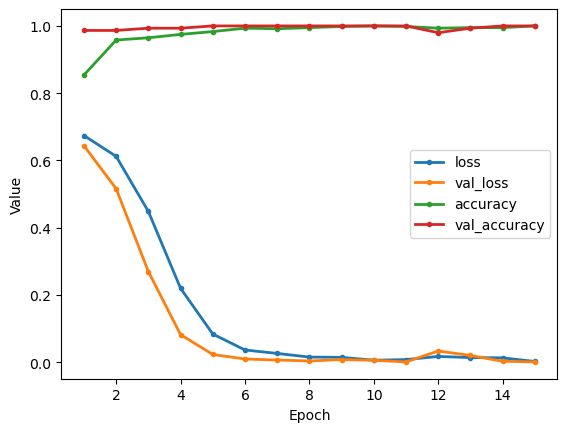

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYX,YYY
276,0.000000,0.0,0.0,0.0,0.0,0.000000,0.001431,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.001054,0.0,0.0,0.0,0.0,0.001054,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.001272,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001272,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.001692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (745, 8194)
X_test: (187, 8194)
y_train: (745,)
y_test: (187,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,097,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,141,185 (8.17 MB)

 Trainable params: 2,141,185 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.5625 - loss: 0.6931

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5572 - loss: 0.6930  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5630 - loss: 0.6930 - val_accuracy: 0.5705 - val_loss: 0.6897


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6406 - loss: 0.6900

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7718 - loss: 0.6864 - val_accuracy: 0.9329 - val_loss: 0.6677


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9219 - loss: 0.6671

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9754 - loss: 0.6506 - val_accuracy: 0.9933 - val_loss: 0.5764


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.5748

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.5266 - val_accuracy: 0.9933 - val_loss: 0.3459


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.3255

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.2648 - val_accuracy: 0.9933 - val_loss: 0.0929


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0755

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0606 - val_accuracy: 0.9933 - val_loss: 0.0359


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0134

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0102 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9933 - val_loss: 0.0146


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0028

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0028 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9933 - val_loss: 0.0162


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0072

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9933 - val_loss: 0.0300


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.1738e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010     

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9933 - val_loss: 0.0167


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.9182e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.1707e-04 - val_accuracy: 0.9933 - val_loss: 0.0135


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1781e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3820e-04 - val_accuracy: 0.9933 - val_loss: 0.0152


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.3005e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2281e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1751e-04 - val_accuracy: 0.9933 - val_loss: 0.0177



[Train Accuracy: 100.00% - Test Accuracy: 99.47%]


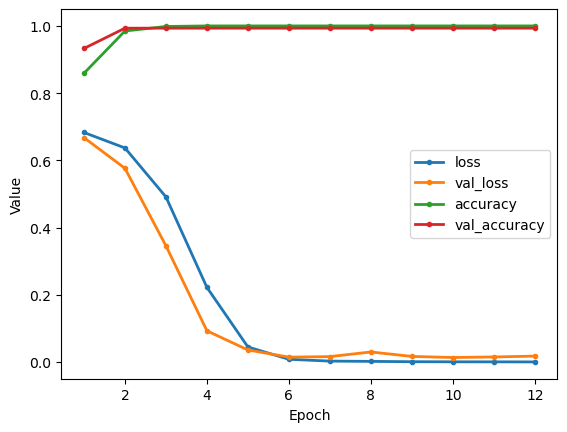

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYVT,YYVV,YYYH,YYYL,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
276,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.0,0.0,0.0,0.0,0.0,0.001055,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001274,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      24,038,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,079,873 (91.86 MB)

 Trainable params: 24,079,873 (91.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.6562 - loss: 0.6931

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5898 - loss: 0.6935 

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5599 - loss: 0.6936

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5479 - loss: 0.6935

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5358 - loss: 0.6935

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5285 - loss: 0.6935

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5264 - loss: 0.6934

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5240 - loss: 0.6934

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5227 - loss: 0.6933

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5204 - loss: 0.6932 - val_accuracy: 0.5973 - val_loss: 0.6892


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6562 - loss: 0.6891

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6602 - loss: 0.6888 

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6866 - loss: 0.6884

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7083 - loss: 0.6880

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7223 - loss: 0.6876

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7339 - loss: 0.6872

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7457 - loss: 0.6867

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7551 - loss: 0.6863

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7624 - loss: 0.6858

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7736 - loss: 0.6851 - val_accuracy: 0.9530 - val_loss: 0.6687


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9219 - loss: 0.6673

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9414 - loss: 0.6651

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9488 - loss: 0.6632

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9485 - loss: 0.6605

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9475 - loss: 0.6591

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9460 - loss: 0.6565

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9460 - loss: 0.6551

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9464 - loss: 0.6526 - val_accuracy: 0.9530 - val_loss: 0.6053


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9531 - loss: 0.5892

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9531 - loss: 0.5825

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9482 - loss: 0.5794

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9423 - loss: 0.5777

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9398 - loss: 0.5753

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.5718

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9394 - loss: 0.5683

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9404 - loss: 0.5645

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9418 - loss: 0.5589 - val_accuracy: 0.9732 - val_loss: 0.4699


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.4256

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9922 - loss: 0.4305

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9913 - loss: 0.4270

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9920 - loss: 0.4183

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9924 - loss: 0.4140

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9929 - loss: 0.4090

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9930 - loss: 0.4039

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9932 - loss: 0.3984

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9936 - loss: 0.3898 - val_accuracy: 0.9799 - val_loss: 0.2715


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9844 - loss: 0.2298

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9883 - loss: 0.2258

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9905 - loss: 0.2203

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9915 - loss: 0.2111

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9920 - loss: 0.2067

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9925 - loss: 0.2023

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9930 - loss: 0.1983

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9934 - loss: 0.1946

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9940 - loss: 0.1887 - val_accuracy: 0.9933 - val_loss: 0.1153


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0908

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0819

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0772

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0737

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0681

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0635

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0616

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.0448


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0138

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0139

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0139

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0137

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0136

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0132

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0130

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0128

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0291


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0059

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0055

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0053

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0051

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0050

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0049

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0048

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0048

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0047

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0177


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0025

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0022

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0021

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0021

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0021

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0021

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0021

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0021

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0127


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 8.2702e-04

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 9.4959e-04

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0010    

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0115


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0011

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0011

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0010

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0010

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0010

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0010

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0010

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0112


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.9931e-04

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0010    

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 9.5128e-04

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 9.2338e-04

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 9.1161e-04

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 8.9840e-04

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 8.9154e-04

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 8.7832e-04

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 8.6465e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 8.4283e-04 - val_accuracy: 1.0000 - val_loss: 0.0100


Epoch 14/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0010

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 8.9560e-04

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 7.9396e-04

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 7.7544e-04

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 7.5439e-04

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 7.3549e-04

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 7.2254e-04

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 7.0872e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.8973e-04 - val_accuracy: 1.0000 - val_loss: 0.0090


Epoch 15/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 4.5873e-04

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 5.1814e-04

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 5.2196e-04

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 5.9358e-04

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 6.2447e-04

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 6.4331e-04

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 6.4121e-04

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 6.3915e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 6.3489e-04 - val_accuracy: 1.0000 - val_loss: 0.0102


Epoch 16/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 3.0393e-04

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 3.3645e-04

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.3894e-04

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.4622e-04

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.6330e-04

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.7299e-04

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.7490e-04

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 3.7490e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 3.7359e-04 - val_accuracy: 1.0000 - val_loss: 0.0104


Epoch 17/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.4426e-04

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 3.8457e-04

 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 3.9959e-04

 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 4.0664e-04

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 4.0817e-04

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 4.2587e-04

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 4.3136e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 4.3805e-04 - val_accuracy: 1.0000 - val_loss: 0.0091



[Train Accuracy: 100.00% - Test Accuracy: 98.93%]


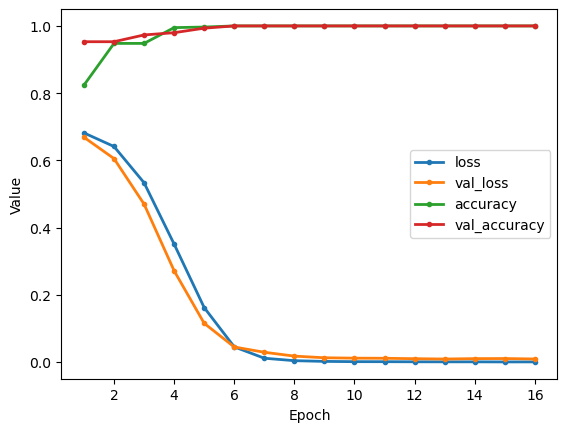

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [25]:
report.save()

Report saved as Output/Reports/HB-PHD/report_XFNP676V.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################